### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import joblib

### Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/My Drive/Water_monitoring/'

/content/gdrive/My Drive/Water_monitoring


### Upload excel file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving history_klang.xlsx to history_klang.xlsx


### Edit and read the excel file

In [ ]:
## load the data 
df_from_excel= pd.read_excel('history_klang.xlsx',
                            sheet_name = 'My sheet', 
                            header = [0], 
                            index_col = 0,
                            usecols = "A, D:H,K:O, R:V, Y:AC, AF:AJ, AM:AQ, AT:AX, BA:BE, BL",   #Only read the necessary columns
                            skiprows= [3254,3255],   #These rows are NaN
                            na_values = 'NaN')
df_from_excel = df_from_excel.rename(columns = {'Occurance (1:YES; 0:NO)': 'Occurance'}, inplace = False)

### View the excel file

In [ ]:
df_from_excel.head(10)

,Temp_0(°c),Rain_0(mm),Humidity_0(%),Cloud_0(%),Pressure_0(mb),Temp_3(°c),Rain_3(mm),Humidity_3(%),Cloud_3(%),Pressure_3(mb),Temp_6(°c),Rain_6(mm),Humidity_6(%),Cloud_6(%),Pressure_6(mb),Temp_9(°c),Rain_9(mm),Humidity_9(%),Cloud_9(%),Pressure_9(mb),Temp_12(°c),Rain_12(mm),Humidity_12(%),Cloud_12(%),Pressure_12(mb),Temp_15(°c),Rain_15(mm),Humidity_15(%),Cloud_15(%),Pressure_15(mb),Temp_18(°c),Rain_18(mm),Humidity_18(%),Cloud_18(%),Pressure_18(mb),Temp_21(°c),Rain_21(mm),Humidity_21(%),Cloud_21(%),Pressure_21(mb),Occurance
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Tue 01, Jan 2013",25,0.2,94,76,1009,24,0.0,93,61,1008,24,0.0,91,57,1009,31,0.0,60,44,1010,33,0.0,53,31,1008,30,0.0,63,44,1007,28,0.0,74,46,1009,26,0.5,85,34,1010,0
"Wed 02, Jan 2013",26,1.3,89,61,1009,25,1.4,91,41,1009,25,2.2,91,60,1010,29,0.1,72,35,1011,31,0.9,64,54,1010,30,2.6,73,52,1008,27,2.8,85,79,1010,27,0.6,89,31,1011,0
"Thu 03, Jan 2013",26,4.4,91,48,1011,25,0.7,92,63,1010,25,1.2,92,65,1010,30,0.9,71,88,1012,33,1.0,57,37,1010,29,0.2,72,80,1009,27,0.2,81,39,1009,27,0.0,82,44,1010,0
"Fri 04, Jan 2013",26,0.0,85,31,1010,26,0.0,86,27,1009,25,0.0,85,26,1010,33,0.0,57,15,1010,33,0.2,56,28,1008,29,0.9,74,51,1006,27,1.3,87,71,1008,26,1.1,87,68,1008,0
"Sat 05, Jan 2013",25,3.1,92,80,1009,25,0.7,92,88,1008,25,0.0,93,60,1009,29,0.9,74,39,1010,33,1.3,54,38,1008,32,0.2,60,23,1006,28,0.0,78,21,1007,27,0.0,81,17,1008,0
"Sun 06, Jan 2013",26,0.0,82,24,1008,26,0.0,81,24,1007,26,0.0,80,21,1009,32,0.0,54,8,1010,32,0.0,53,10,1008,31,0.0,60,8,1007,28,0.0,81,10,1008,27,0.1,88,11,1010,0
"Mon 07, Jan 2013",26,0.0,86,11,1010,26,0.0,85,8,1009,26,0.0,83,9,1009,31,0.0,61,8,1009,32,0.0,56,9,1008,31,0.0,65,12,1006,28,0.0,83,11,1008,27,0.5,87,26,1010,0
"Tue 08, Jan 2013",26,0.0,87,33,1010,26,0.0,86,44,1009,26,0.0,84,44,1010,31,0.1,63,24,1011,32,0.0,54,30,1009,31,0.0,60,35,1008,28,0.0,77,47,1009,27,0.1,80,59,1010,0
"Wed 09, Jan 2013",27,0.0,81,69,1010,26,0.0,79,48,1009,26,0.0,78,44,1010,30,0.1,61,69,1011,31,0.0,57,51,1010,29,0.1,68,56,1008,27,0.0,81,66,1010,26,0.0,83,46,1010,0


In [ ]:
df_from_excel.tail(10)

,Temp_0(°c),Rain_0(mm),Humidity_0(%),Cloud_0(%),Pressure_0(mb),Temp_3(°c),Rain_3(mm),Humidity_3(%),Cloud_3(%),Pressure_3(mb),Temp_6(°c),Rain_6(mm),Humidity_6(%),Cloud_6(%),Pressure_6(mb),Temp_9(°c),Rain_9(mm),Humidity_9(%),Cloud_9(%),Pressure_9(mb),Temp_12(°c),Rain_12(mm),Humidity_12(%),Cloud_12(%),Pressure_12(mb),Temp_15(°c),Rain_15(mm),Humidity_15(%),Cloud_15(%),Pressure_15(mb),Temp_18(°c),Rain_18(mm),Humidity_18(%),Cloud_18(%),Pressure_18(mb),Temp_21(°c),Rain_21(mm),Humidity_21(%),Cloud_21(%),Pressure_21(mb),Occurance
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Wed 17, Nov 2021",25,0.3,90,76,1009,25,0.2,90,50,1008,25,0.3,90,87,1008,26,0.0,87,40,1010,30,0.2,71,86,1010,31,0.6,66,81,1007,28,0.2,78,75,1007,26,0.0,80,44,1009,0
"Thu 18, Nov 2021",25,0.0,87,31,1010,24,0.0,90,48,1008,24,0.0,90,50,1008,26,0.0,82,33,1010,31,0.0,62,36,1009,30,0.0,63,38,1006,28,0.0,76,29,1006,26,0.0,82,26,1008,0
"Fri 19, Nov 2021",25,0.0,90,32,1009,25,0.4,92,65,1007,24,0.3,90,73,1007,26,0.5,82,63,1009,30,0.4,70,73,1009,31,0.1,65,87,1006,30,0.1,75,72,1005,26,0.0,84,15,1007,0
"Sat 20, Nov 2021",25,0.0,85,27,1008,25,0.6,88,80,1006,25,0.5,87,78,1006,27,0.0,77,19,1009,32,0.0,63,16,1008,32,0.0,61,24,1005,29,0.0,73,20,1006,27,0.0,80,31,1008,0
"Sun 21, Nov 2021",25,1.0,92,81,1009,25,0.0,90,53,1007,25,0.2,89,81,1007,26,0.1,85,75,1009,30,0.8,68,54,1009,31,0.1,64,89,1006,28,0.1,77,73,1007,27,0.0,82,51,1009,0
"Mon 22, Nov 2021",25,0.0,87,26,1009,25,0.4,89,88,1007,25,0.8,89,79,1008,27,1.0,84,86,1010,29,1.4,79,85,1010,28,1.1,79,83,1007,26,0.6,86,74,1007,26,0.0,87,83,1009,0
"Tue 23, Nov 2021",25,0.0,87,57,1009,25,0.5,90,80,1007,24,0.1,91,100,1007,27,0.1,83,86,1009,30,0.3,73,79,1009,31,0.1,66,88,1006,30,0.1,77,87,1005,26,0.0,84,16,1008,0
"Wed 24, Nov 2021",26,0.2,88,72,1009,25,0.6,88,70,1007,25,0.6,86,67,1008,27,0.8,81,83,1010,29,1.2,76,71,1010,28,1.7,80,67,1007,26,1.2,84,100,1007,26,0.0,86,95,1010,0
"Thu 25, Nov 2021",25,0.1,88,55,1010,25,0.1,89,56,1008,24,0.0,87,47,1008,24,0.0,86,81,1010,27,0.0,81,81,1010,29,0.0,69,45,1007,28,0.0,75,42,1007,26,0.0,84,35,1009,0


### Correlation Analysis

In [ ]:
corr = df_from_excel.corr()
print(corr)

                 Temp_0(°c)  Rain_0(mm)  ...  Pressure_21(mb)  Occurance
Temp_0(°c)         1.000000   -0.125739  ...        -0.206138   0.001688
Rain_0(mm)        -0.125739    1.000000  ...         0.015017   0.065597
Humidity_0(%)     -0.498959    0.320779  ...         0.116358   0.066093
Cloud_0(%)        -0.269557    0.285876  ...        -0.086708   0.050802
Pressure_0(mb)    -0.267139    0.016707  ...         0.734303  -0.010119
Temp_3(°c)         0.769626   -0.103558  ...        -0.269294   0.009878
Rain_3(mm)        -0.092192    0.486522  ...        -0.026814   0.087744
Humidity_3(%)     -0.425579    0.313184  ...         0.102156   0.058162
Cloud_3(%)        -0.262386    0.231894  ...        -0.103464   0.042485
Pressure_3(mb)    -0.208317    0.004224  ...         0.743814  -0.007995
Temp_6(°c)         0.624057   -0.120320  ...        -0.190045   0.007531
Rain_6(mm)        -0.031033    0.277998  ...        -0.044356   0.056893
Humidity_6(%)     -0.353722    0.300694  ...       

### Split the data into train, test, and validation data

In [ ]:
# split into train and test 
dfTrain = df_from_excel[:]
dfTest = df_from_excel[1500:]
dfCheck = df_from_excel[1500:]

### Split features from target variable 

In [ ]:
trainLabel = np.asarray(dfTrain['Occurance'])
trainData = np.asarray(dfTrain.drop('Occurance',1))
testLabel = np.asarray(dfTest['Occurance'])
testData = np.asarray(dfTest.drop('Occurance',1))

### Normalize the data 
Make the interpretation of the model more easier by looking at its weights

In [ ]:
means = np.mean(trainData, axis=0)
stds = np.std(trainData, axis=0)

trainData = (trainData - means)/stds
testData = (testData - means)/stds

### Train and evaluate the model

In [ ]:
FloodCheck = LogisticRegression(class_weight={0:1,1:10},solver='saga',penalty='l2')
FloodCheck.fit(trainData, trainLabel)
accuracy = FloodCheck.score(testData, testLabel)
print("accuracy = ", accuracy * 100, "%")

accuracy =  88.2420091324201 %


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


### Interpret the model

Text(0.5, 0, 'Importance')

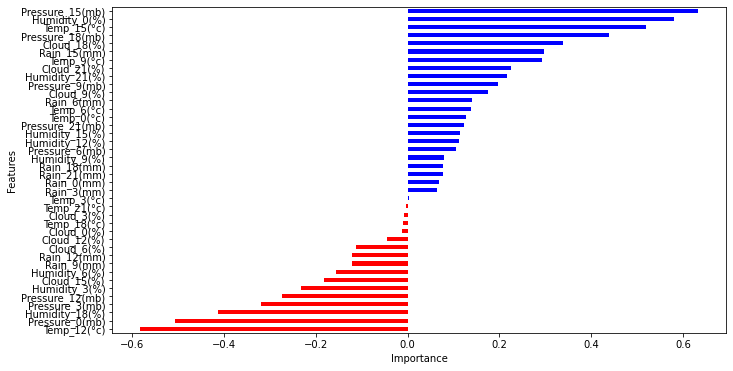

In [ ]:
coeff = list(FloodCheck.coef_[0])
labels = list(dfTrain.drop('Occurance',1).columns)
 
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

In [ ]:
total_p = 0
total_n = 0

for count in range(40):
  if coeff[count] >=0:
    total_p = total_p + coeff[count]
  else:
    total_n = total_n + coeff[count]

for count in range(40):
  if coeff[count] >=0:
    print("Importance of {0} is {1}%".format(labels[count], round(coeff[count]*100/total_p,2)))
  else:
    print("Importance of {0} is -{1}%".format(labels[count], round(coeff[count]*100/total_n,2)))

Importance of Temp_0(°c) is 2.46%
Importance of Rain_0(mm) is 1.34%
Importance of Humidity_0(%) is 11.29%
Importance of Cloud_0(%) is -0.4%
Importance of Pressure_0(mb) is -16.35%
Importance of Temp_3(°c) is 0.08%
Importance of Rain_3(mm) is 1.23%
Importance of Humidity_3(%) is -7.5%
Importance of Cloud_3(%) is -0.27%
Importance of Pressure_3(mb) is -10.32%
Importance of Temp_6(°c) is 2.67%
Importance of Rain_6(mm) is 2.73%
Importance of Humidity_6(%) is -5.02%
Importance of Cloud_6(%) is -3.61%
Importance of Pressure_6(mb) is 2.06%
Importance of Temp_9(°c) is 5.71%
Importance of Rain_9(mm) is -3.93%
Importance of Humidity_9(%) is 1.55%
Importance of Cloud_9(%) is 3.41%
Importance of Pressure_9(mb) is 3.82%
Importance of Temp_12(°c) is -18.78%
Importance of Rain_12(mm) is -3.89%
Importance of Humidity_12(%) is 2.19%
Importance of Cloud_12(%) is -1.43%
Importance of Pressure_12(mb) is -8.83%
Importance of Temp_15(°c) is 10.09%
Importance of Rain_15(mm) is 5.8%
Importance of Humidity_15(

### Save and load model

In [ ]:
## save model
joblib.dump([FloodCheck, means, stds], 'FloodModel.pkl')

## load model
FloodLoadedModel, means, stds = joblib.load('FloodModel.pkl')
accuracyModel = FloodLoadedModel.score(testData, testLabel)
print("accuracy = ",accuracyModel * 100,"%")

accuracy =  88.2420091324201 %


### Make predictions based on historical weather data

In [ ]:
sampleData = dfCheck[:]

# prepare sample
sampleDataFeatures = np.asarray(sampleData.drop('Occurance',1))
sampleDataFeatures = (sampleDataFeatures - means)/stds

# predict
predictionProbability = FloodCheck.predict_proba(sampleDataFeatures)
prediction = FloodCheck.predict(sampleDataFeatures)
print('Probability:', predictionProbability)
print('prediction:', prediction)

Probability: [[0.92374472 0.07625528]
 [0.9149139  0.0850861 ]
 [0.65892599 0.34107401]
 ...
 [0.50306648 0.49693352]
 [0.82247974 0.17752026]
 [0.79039109 0.20960891]]
prediction: [0 0 0 ... 0 0 0]


In [ ]:
percentage = []
for length in range(len(dfCheck)):
  result=(predictionProbability[length][1])*100
  percentage.append(round(result))

dfCheck.insert(41, "Flood Prediction(%)", percentage, True)

In [ ]:
dfCheck[-130:-80]

,Temp_0(°c),Rain_0(mm),Humidity_0(%),Cloud_0(%),Pressure_0(mb),Temp_3(°c),Rain_3(mm),Humidity_3(%),Cloud_3(%),Pressure_3(mb),Temp_6(°c),Rain_6(mm),Humidity_6(%),Cloud_6(%),Pressure_6(mb),Temp_9(°c),Rain_9(mm),Humidity_9(%),Cloud_9(%),Pressure_9(mb),Temp_12(°c),Rain_12(mm),Humidity_12(%),Cloud_12(%),Pressure_12(mb),Temp_15(°c),Rain_15(mm),Humidity_15(%),Cloud_15(%),Pressure_15(mb),Temp_18(°c),Rain_18(mm),Humidity_18(%),Cloud_18(%),Pressure_18(mb),Temp_21(°c),Rain_21(mm),Humidity_21(%),Cloud_21(%),Pressure_21(mb),Occurance,Flood Prediction(%)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Tue 20, Jul 2021",27,0.0,75,19,1010,26,0.0,76,22,1009,26,0.0,78,19,1009,28,0.0,76,23,1011,31,0.0,64,23,1011,31,0.0,62,21,1009,30,0.0,68,17,1008,28,0.0,78,15,1010,0,22
"Wed 21, Jul 2021",27,0.0,74,27,1010,26,0.1,76,43,1010,25,0.1,81,68,1010,27,0.0,79,41,1011,30,0.0,65,39,1011,32,0.0,52,30,1009,31,0.0,55,46,1008,28,0.0,69,45,1009,0,36
"Thu 22, Jul 2021",27,0.0,75,36,1010,26,0.0,78,38,1009,26,0.0,81,29,1009,28,0.1,78,47,1010,31,0.2,63,59,1010,32,0.1,57,57,1008,31,0.0,62,25,1007,28,0.0,73,19,1009,0,13
"Fri 23, Jul 2021",28,0.0,75,22,1010,27,0.0,77,23,1009,26,0.0,79,26,1009,28,0.0,73,33,1010,31,0.0,57,57,1010,32,0.0,53,67,1008,31,0.0,57,49,1007,28,0.0,66,47,1008,0,20
"Sat 24, Jul 2021",27,0.1,74,61,1009,26,0.6,81,84,1009,25,0.9,86,61,1009,27,0.0,80,25,1010,30,0.0,66,30,1010,32,0.0,60,31,1009,30,0.0,68,20,1008,28,0.0,79,18,1009,0,21
"Sun 25, Jul 2021",27,0.2,81,49,1010,26,1.6,85,64,1010,25,5.3,92,76,1010,26,6.3,86,73,1011,30,1.7,68,63,1011,32,1.1,59,73,1008,30,0.1,67,80,1008,28,0.1,79,61,1009,0,32
"Mon 26, Jul 2021",27,0.0,83,14,1010,26,0.3,85,43,1008,26,0.8,86,82,1008,27,0.8,78,72,1010,31,0.7,62,66,1010,32,0.6,60,68,1008,31,0.2,67,55,1007,29,0.0,78,7,1009,0,20
"Tue 27, Jul 2021",27,0.0,78,13,1009,26,0.2,82,44,1008,25,0.4,85,85,1009,27,0.4,79,80,1010,31,0.3,62,77,1010,32,0.0,57,48,1007,30,0.0,66,30,1006,29,0.0,72,10,1007,0,7
"Wed 28, Jul 2021",27,0.0,76,11,1009,27,0.0,78,36,1008,25,0.1,81,75,1009,27,0.1,76,64,1010,31,0.3,61,80,1010,32,0.1,56,83,1008,31,0.1,61,60,1007,28,0.0,72,44,1008,0,24
